# Test if driving slow mode with $T_e \gg T_i$ give compariable results between simulation and analytic solution

In [6]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from gk_solver.gk_apar0 import dispersion, res_0, res_i
from gk_solver.util import real_imag, list2complex
%matplotlib inline

### Functions to construct time series easily

In [7]:
def ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                   wbar_0, wbar_arr, tbar_arr, turnoff=None):
    """
    return time series for B_parallel and phi
    """
    
    def phi_b(tbar):
        """
            vector(\phi(t), B(t))
    """
        res = res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar, turnoff=turnoff)
        for wbar_i in wbar_arr:
            res += res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar, turnoff=turnoff)
        return res
    
    phi_b_arr = np.array([phi_b(tbar) for tbar in tbar_arr])
    return phi_b_arr

In [8]:
def eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi):
    """
    find the eigenmodes of the gk system.
    currently hard coded the initial values for beta_i << 1, Ti = Te.
    """
    # slow mode
    guess_sm_1 = np.sqrt(bi) * 1.4 * (1-0.5j)
    guess_sm_2 = np.sqrt(bi) * 1.4 * (-1-0.5j)
    # entropy mode
    guess_sm_3 = (-0.2 * np.log10(bi) -0.58) * 1j

    f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))
    wbar_arr = []
    for guess in [guess_sm_1, guess_sm_2, guess_sm_3]:
        res = scipy.optimize.fsolve(f, real_imag(guess))
        wbar = list2complex(res)
        if np.abs(wbar.real) < 1.e-10:
            wbar = 1j * wbar.imag
        wbar_arr += [wbar]
    return wbar_arr

Parameters setup

In [15]:
ti_te = .01
kperp_rhoi = 0.2
wbar_0 = 0.35
bi = 0.01
bpar0 = 10
mi_me = 1836

texts = "{0}{1}\n".format(r'$\beta_i$=',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1}\n".format(r'$\delta B_{\mathbf{k}\parallel 0}=$', bpar0) +\
    "{0}{1:.2f}\n".format(r'$\overline{\omega}_0=$', wbar_0)


Eigenmodes / simple poles

In [16]:
wbar_arr = eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi)
print(wbar_arr)

[(0.39692062237700992-0.0020940512930690473j), (-0.39692062237702253-0.0020940512930693422j), (-0-0.1851598067603516j)]


In [54]:
tbar_arr = np.linspace(0, 500, 1000)

In [55]:
phi_bpar_arr = ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                              wbar_0, wbar_arr, tbar_arr)

In [56]:
phi_arr = np.abs(phi_bpar_arr[:, 0])
bpar_arr = np.abs(phi_bpar_arr[:,1])

Make $\phi(t)$ plot

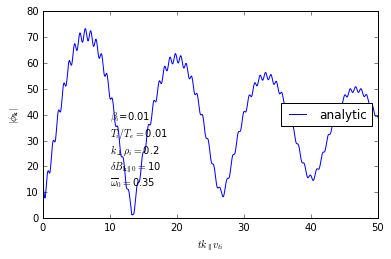

In [57]:
fig_phi_temp = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr * np.sqrt(bi), phi_arr*bpar0, label = 'analytic')
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

make $B_\parallel$ plot

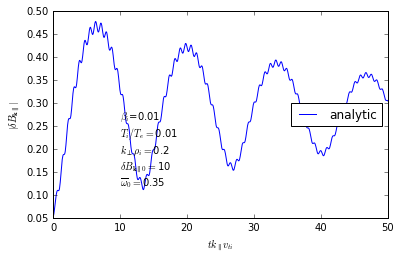

In [58]:
fig_bpar_temp = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr * np.sqrt(bi), bpar_arr * bpar0, 
             label = 'analytic')
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

In [59]:
# fig_phi_tf.savefig('fig_phi_tf.eps')
# fig_bpar_tf.savefig('fig_bpar_tf.eps')

## comare with simulation 

In [1]:
data_dir = '/Volumes/yuguang_sd/data/agk/lin_response/lin_slow_1'
i = 4
filename_bpar = data_dir + '/lin_slow_{0:s}.bpar'.format(str(i))
filename_phi = data_dir + '/lin_slow_{0:s}.phi'.format(str(i))

In [2]:
dtype_bpar = {'names': ('f1', 't', 'f2', 'bpar2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
dtype_phi = {'names': ('f1', 't', 'f2', 'phi2', 'f3', 'f4', 'h1', 'h2'),
              'formats': ('S2', 'f4', 'S10', 'f4', 'S10', 'S10', 'f4', 'f4')}
data_bpar = np.loadtxt(filename_bpar, dtype = dtype_bpar)
data_phi = np.loadtxt(filename_phi, dtype = dtype_bpar)

NameError: name 'np' is not defined

In [62]:
def readColumn(data, column):
    return np.array([elem[column] for elem in data])

In [63]:
bpar = np.sqrt(readColumn(data_bpar, 3))
t_bpar = readColumn(data_bpar, 1)
phi = np.sqrt(readColumn(data_phi, 3))
t_phi = readColumn(data_phi, 1)

In [69]:
dt_label='0.01'
texts = "{0}{1}\n".format(r'$\beta_i=$',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1:.1f}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1:.1f}\n".format(r'$\delta B_{\mathbf{k}\parallel 0}=$', bpar0) +\
    "{0}{1:.2f}\n".format(r'$\overline{\omega}_0=$',wbar_0)

### plot $\delta B_\parallel$

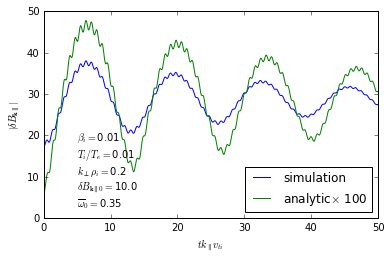

In [70]:
fig_bpar = plt.figure(figsize=[6, 6*0.618])
plt.plot(t_bpar, bpar * np.sqrt(8) * 10, label = 'simulation')
plt.plot(tbar_arr * np.sqrt(bi), bpar_arr * bpar0 * 100, label = 'analytic' + r'$\times$ 100')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
plt.legend(loc='lower right')
ax = plt.gca()
plt.text(0.1, 0., texts, transform=ax.transAxes)

### plot $\phi$

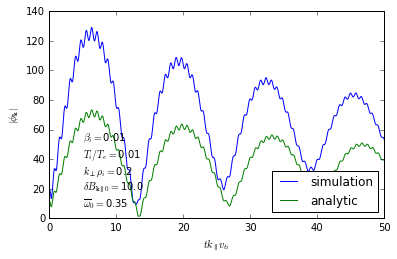

In [71]:
fig_phi = plt.figure(figsize=[6, 6*0.618])
plt.plot(t_phi, phi, label = 'simulation')
plt.plot(tbar_arr * np.sqrt(bi), phi_arr*bpar0, label = 'analytic')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
plt.legend(loc='lower right')
ax = plt.gca()
plt.text(0.1, 0, texts, transform=ax.transAxes)

In [73]:
# fig_bpar.savefig('fig_bpar_temp_1.eps')
# fig_phi.savefig('fig_phi_temp_1.eps')